In [2]:
import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import os, gc 

from pinnPack import pinnUtils, physicsNN
from ssfmPack import utils

In [3]:
gc.collect()
torch.cuda.empty_cache()

if torch.cuda.is_available():
    torch.randn(1).to('cuda') 

In [4]:
truthPulse = np.load('results/Cpulse.npy') 
truthTime = np.load('results/CtimeArr.npy') 
truthLength = np.load('results/ClengthArr.npy')

# Data Preparation

In [17]:
num_init = 500 #number of initial points
num_bound = 500 #number of boundary points, each
num_col = 40000 #number of collocation points 
num_val = 7000 #number of validation sampling points

In [18]:
#IC Function
def sechPulsePINN(time, amplitude, pulsewidth): 
    return amplitude/np.cosh(time/pulsewidth)

pulsewidth = 0.58
L = truthLength.max() #m
T = truthTime.max()

#Pulse Parameters 
parameters = {
    'L': L, #10m
    'T': T, #4ps
    'A0': np.sqrt(22.05),  # unit = (W^1/2)
    'pw': pulsewidth,  #0.58ps   
    'gamma': 18.4e-3,      # unit = (1/Wm)
    'beta2': -5.23e-3,     # unit = (s^2/m)
    'beta3': 4.27e-5,      # unit = (s^3/m)
    'alpha': 0.05*np.log(10)/10 # unit = Nepers/m
}
parameters['alpha'] = parameters['alpha']*L
parameters['beta2'] = parameters['beta2']*L/T**2
parameters['beta3'] = parameters['beta3']*L/T**3
parameters['gamma'] = parameters['gamma']*L

#Training Dataset 
#T domain is normalized into (-1,1); Z domain is normalized into (0,1) 
t_init = np.linspace(-T/T,T/T,num_init).reshape(-1,1) #Initial
x_init = np.zeros((num_init, 1))
u_init = sechPulsePINN(t_init, parameters['A0'], parameters['pw']/T).reshape(-1,1)
tx_init = (t_init, x_init)
uv_init = (u_init, np.zeros_like(u_init))

tU_bound = np.full((num_bound,1), -T/T, dtype = float)
xU_bound = pinnUtils.generate_points(0, L/L, num_bound)
tL_bound = np.full((num_bound, 1,), T/T, dtype = float) 
xL_bound = pinnUtils.generate_points(0, L/L, num_bound)
txU_bound = (tU_bound, xU_bound)
txL_bound = (tL_bound, xL_bound)

tx_col = pinnUtils.generate_points(np.array([-T/T,0]),np.array([T/T,L/L]),num_col, seed = 0) #Collocation
tx_col = (tx_col[:,0].reshape(-1,1), tx_col[:,1].reshape(-1,1))
#Validation Dataset 
tx_val, uv_val = pinnUtils.ssfm_sampling(truthTime/T, truthLength/L, truthPulse, num_val, clipRange = 400, normalized = False)

# Check

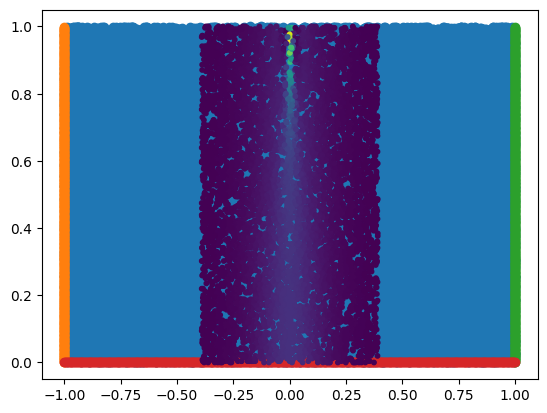

In [19]:
plt.scatter(tx_col[0][:,-1], tx_col[1][:,-1])
plt.scatter(tU_bound[:,-1], xU_bound[:,-1])
plt.scatter(tL_bound[:,-1], xL_bound[:,-1])
plt.scatter(t_init[:,-1], x_init[:,-1])
amplitude = uv_val[0][:,0]**2 + uv_val[1][:,0]**2
plt.scatter(tx_val[0][:, 0], tx_val[1][:, 0], c=amplitude, cmap='viridis', s=10)

In [20]:
print(f"a = {parameters['alpha']}")
print(f"b = {parameters['beta2']}")
print(f"d = {parameters['beta3']}")
print(f"c = {parameters['gamma']}")

a = 0.12664218011467254
b = -0.0034901356499793747
d = 7.018470186877493e-06
c = 0.2024


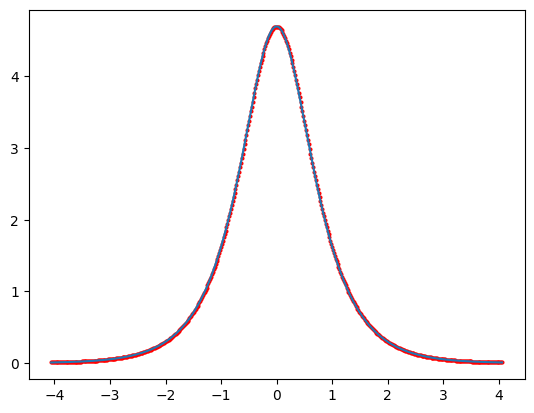

In [21]:
plt.scatter(np.sort(t_init[:,0])*T,
            sechPulsePINN(np.sort(t_init[:,0])*T, parameters['A0'], parameters['pw']),
            color='red', marker='.', s=15)
plt.plot(truthTime, np.abs(truthPulse[0]))

# Vanilla PINN

In [24]:
tx_col[0].shape

(40000, 1)

In [ ]:
path = 'results/complex/vanilla40k'
layers = [2]+[128]*4+[2]
optimizer = 'Adam'
activation = 'tanh' 

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 10, scheduler = True)
piNN.optimizer = pinnUtils.choose_optimizer('adam', piNN.dnn.parameters(), lr = 1e-4)
piNN.train(epochs =40000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.scheduler = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 700) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 700)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

[DNN] training:   4% 1657/40000 [01:27<35:37, 17.94it/s, loss=0.253, mse=1.44]

# SMOTE Resampling

[DNN] training:   0% 0/40000 [00:00<?, ?it/s, loss=0, mse=inf]/home/andikoputrapk/.conda/envs/newenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
[DNN] training:  28% 11186/40000 [20:29<53:06,  9.04it/s, loss=0.00975, mse=0.435] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

[DNN] training:  99% 39606/40

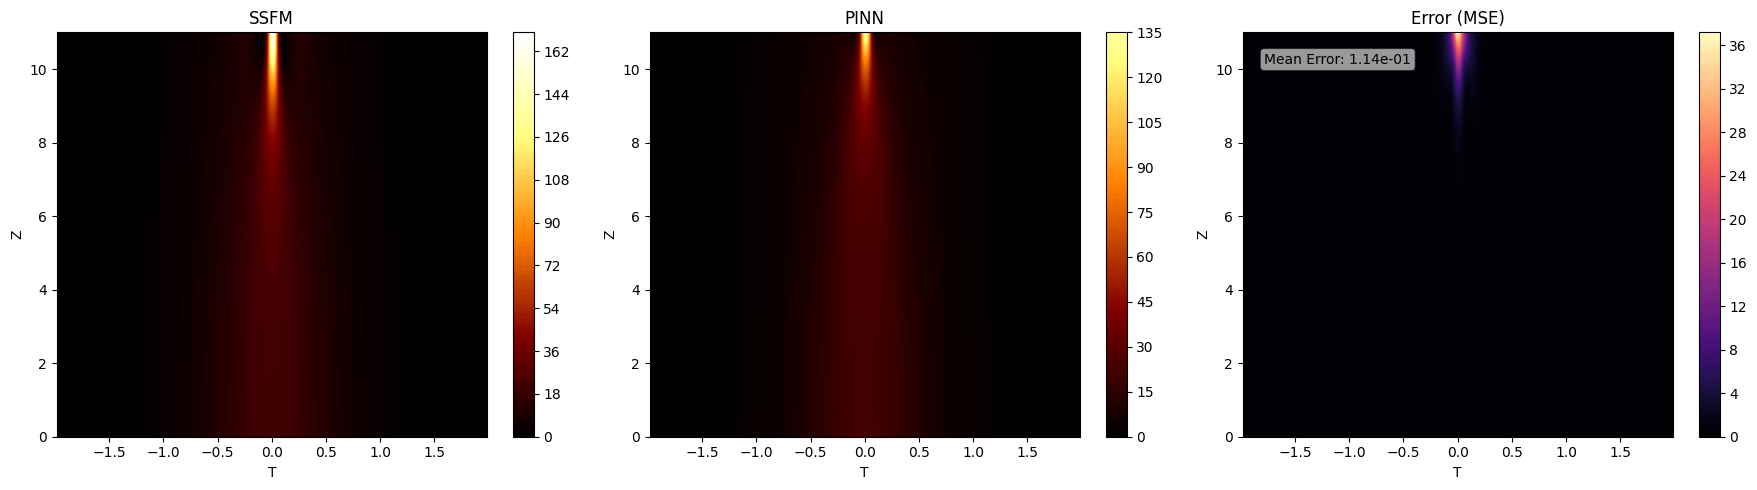

In [17]:
path = 'results/complex/smote'
layers = [2]+[128]*4+[2]
optimizer = 'Adam'
activation = 'tanh' 
smote = {
    'smote_threshold': 0.35,       # Fraction of high-loss points to sample
    'smote_epoch': 5000, 
    'smote_ratio': 0.7,
    'smote_max': 20000,
}


piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 10,
                          smote = smote, scheduler = True)
piNN.optimizer = pinnUtils.choose_optimizer('adam', piNN.dnn.parameters(), lr = 1e-4)
piNN.train(epochs =40000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

# FFE

[DNN/encPBC] training: 100% 40000/40000 [26:23<00:00, 25.27it/s, loss=0.0109, mse=1.96] 


Training using LBFGS


[DNN/encPBC] training: 100% 1/1 [04:07<00:00, 247.47s/it, loss=0.00436, mse=1.96]


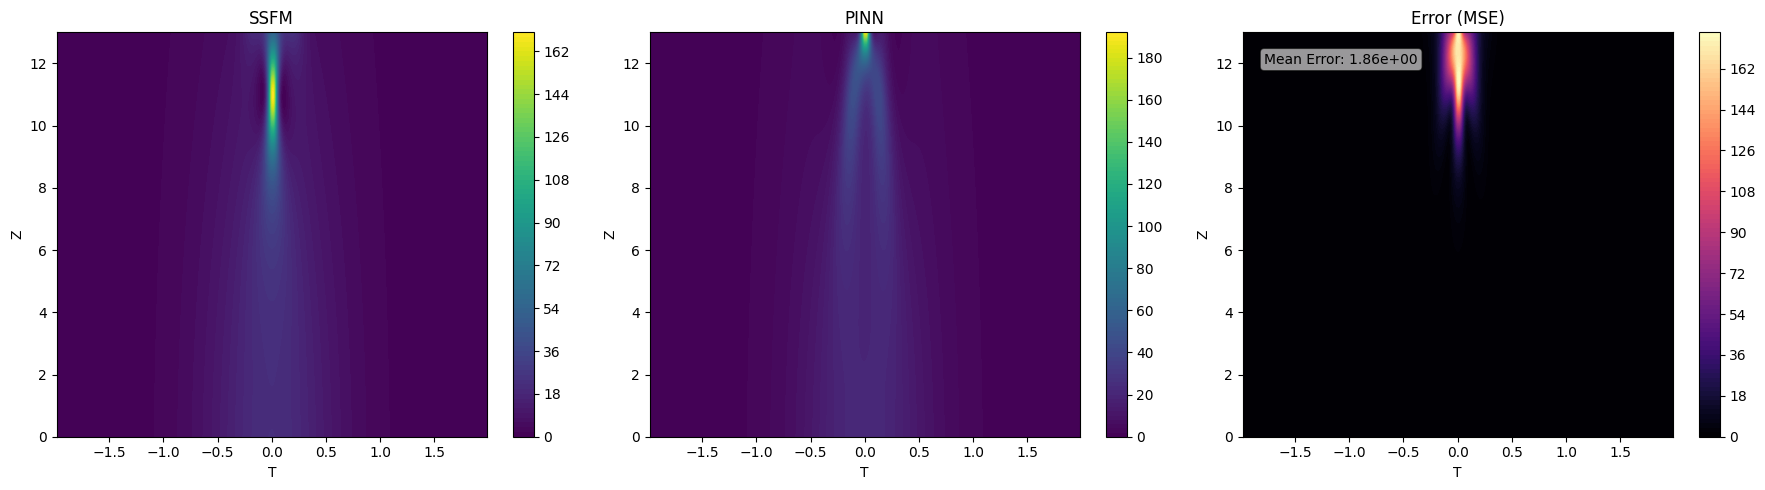

In [13]:
path = 'results/complex/fourier'
layers = [2]+[128]*4+[2]
optimizer = 'Adam'
activation = 'tanh' 

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 10, encode_dim = 2, scheduler = True)
piNN.optimizer = pinnUtils.choose_optimizer('adam', piNN.dnn.parameters(), lr = 1e-4)
piNN.train(epochs =40000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.scheduler = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 700) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 700)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

# Causal Decay

[DNN/causal] training: 100% 40000/40000 [29:04<00:00, 22.93it/s, loss=0.00982, mse=1.88]


Training using LBFGS


[DNN/causal] training: 100% 1/1 [00:00<00:00,  1.77it/s, loss=0.00972, mse=1.88]


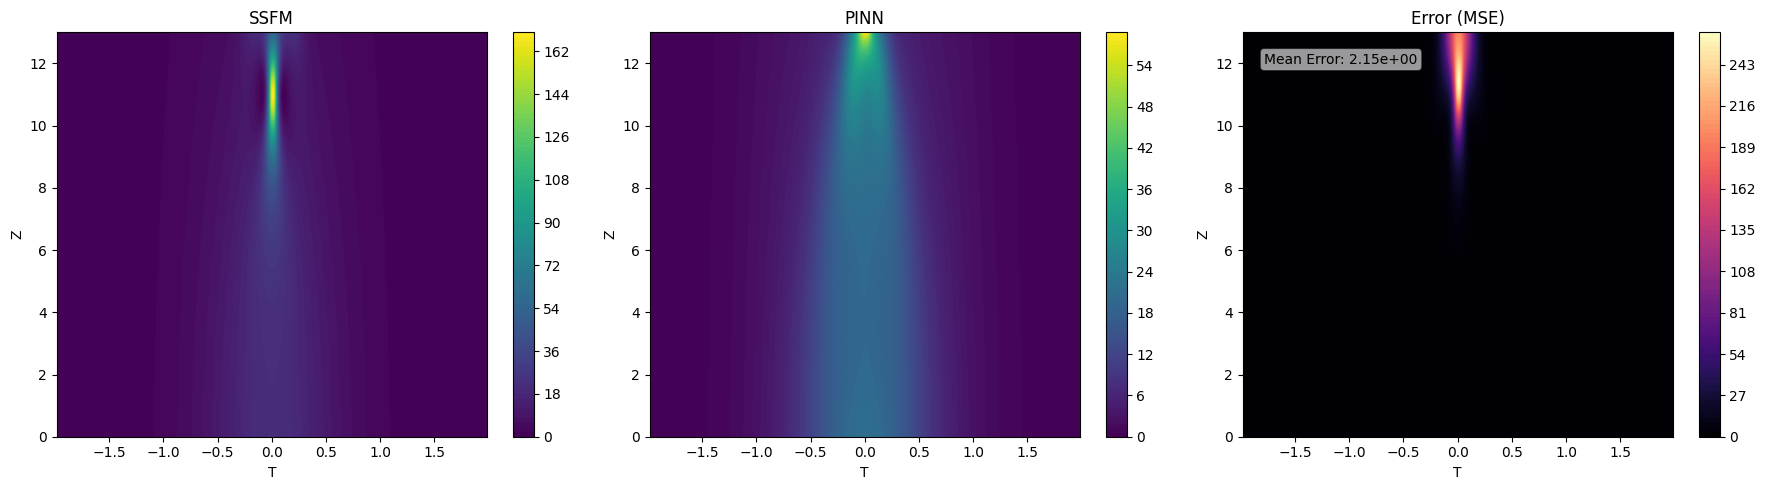

In [12]:
path = 'results/complex/causal'
layers = [2]+[128]*4+[2]
optimizer = 'Adam'
activation = 'tanh' 

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 10, causal_decay = True)
piNN.train(epochs =40000)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 700) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 700)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

# Progressive

Progressive PT learning is used for 6 steps


[PROG] Training on Index: 1: 100% 6000/6000 [02:22<00:00, 42.16it/s, loss=0.00149, mse=3.72]
[PROG] Training on Index: 2: 100% 6000/6000 [02:21<00:00, 42.25it/s, loss=0.00057, mse=2.46] 
[PROG] Training on Index: 3: 100% 6000/6000 [02:26<00:00, 40.85it/s, loss=0.00131, mse=1.81] 
[PROG] Training on Index: 4: 100% 6000/6000 [02:48<00:00, 35.58it/s, loss=0.00376, mse=1.79]
[PROG] Training on Index: 5: 100% 6000/6000 [03:21<00:00, 29.81it/s, loss=0.0255, mse=1.72]
[PROG] Training on Index: 6: 100% 10000/10000 [06:34<00:00, 25.34it/s, loss=0.0487, mse=1.8]


Training using LBFGS


[DNN] training: 100% 1/1 [04:04<00:00, 244.16s/it, loss=0.00889, mse=1.8]


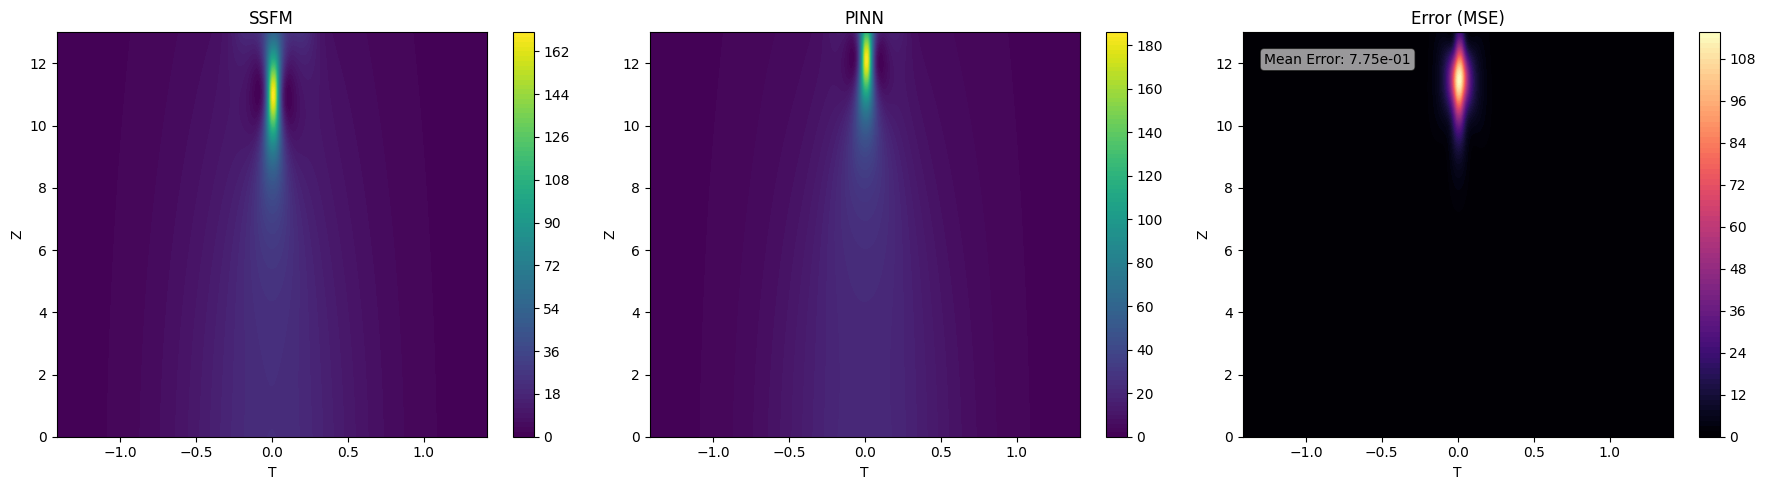

# Curriculum

In [16]:
path = 'results/complex/curriculum'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 
curriculum = {
    'curr_on': 'gamma',
    'curr_initval': 0.1,       # Start with a linear system
    'curr_steps': 5,           
    'version': 2,              
    'curr_epochs': 4000         # You can tweak this based on total epochs
}

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2,
                          curriculum = curriculum)
piNN.train(epochs =25000, curriculum = curriculum)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.curriculum = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

Using curriculum learning on param gamma with target 0.184



[CURR] Training on gamma: 0.14:  90% 6332/7000 [16:29<01:44,  6.40it/s, loss=0.00152, mse=1.37]


KeyboardInterrupt: 

# Curriculum-Causal

In [ ]:
path = 'results/complex/curriculum-causal'
layers = [2,128,128,128,128,2] 
optimizer = 'Adam'
activation = 'tanh' 
curriculum = {
    'curr_on': 'gamma',
    'curr_initval': 0.1,       # Start with a linear system
    'curr_steps': 5,           # 5 stages of curriculum
    'version': 2,              # Fixed steps per stage
    'curr_epochs': 4000         # You can tweak this based on total epochs
}

piNN = physicsNN.phyModel(tx_init, uv_init, tx_col, tx_val, uv_val, txU_bound, txL_bound,
                          layers, parameters, optimizer, act = activation, lambda_init = 2, causal_decay = False,
                          curriculum = curriculum)
piNN.train(epochs =25000, curriculum = curriculum)

print('Training using LBFGS')
piNN.optimizer = pinnUtils.choose_optimizer('lbfgs', piNN.dnn.parameters(), max_iter = 5000)
piNN.curriculum = None
piNN.train(epochs = 1)

os.makedirs(path, exist_ok = True)

#inference
expTime = utils.clipMatrix(truthTime, 500) 
expLength = truthLength
expPulse = utils.clipMatrix(truthPulse, 500)

tMesh, xMesh = np.meshgrid(expTime, expLength)

predPulse = piNN.inference(tMesh/T, xMesh/L) 
error = (predPulse-expPulse)

utils.plotCompare(tMesh, xMesh, predPulse, expPulse, error, nrange = -1, title = f'{path}/result')
piNN.thisLog.history['finalError']: np.mean(np.abs(error)**2)
piNN.save_model(f'{path}/model.pth', f'{path}/records.json')
np.save(path+"/predPulse.npy", predPulse)

Using curriculum learning on param gamma with target 0.184



[CURR] Training on gamma: 0.1: 100% 4000/4000 [10:24<00:00,  6.40it/s, loss=0.000501, mse=3.13]
[CURR] Training on gamma: 0.121: 100% 4000/4000 [10:25<00:00,  6.40it/s, loss=0.000573, mse=2.1] 
[CURR] Training on gamma: 0.142:  12% 494/4000 [01:17<09:16,  6.30it/s, loss=0.0054, mse=1.64] 